# Week 5 ARIMA vs Prophet
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
! pip install sktime

In [2]:
! pip install pmdarima

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sktime/utils/validation/_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


## 1. 10 pts - Exploratory Data Analysis

### 1.A 5 pts Merge the data sets together, should have 735 rows of data

In [4]:
df_co2 = pd.read_csv('hw5_data_co2.csv', parse_dates = ['ds'])
df_temp = pd.read_csv('hw5_data_temp.csv', parse_dates = ['ds'])

In [5]:
print(df_co2.isnull().sum())
print(df_temp.isnull().sum())

print(df_co2.shape)
print(df_temp.shape)

ds     0
co2    0
dtype: int64
ds      0
temp    0
dtype: int64
(735, 2)
(1674, 2)


In [6]:
df_temp

,ds,temp
0,1880-01-01,56.40
1,1880-02-01,56.82
2,1880-03-01,56.74
3,1880-04-01,56.55
4,1880-05-01,56.85
...,...,...
1669,2019-02-01,58.37
1670,2019-03-01,58.59
1671,2019-04-01,58.50
1672,2019-05-01,58.50


In [7]:
df_co2

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
...,...,...
730,2019-01-15,410.920
731,2019-02-15,411.660
732,2019-03-15,412.000
733,2019-04-15,413.510


In [8]:
from datetime import datetime, timedelta
df_co2['ds'] = df_co2['ds'] - timedelta(days=14)
df = pd.merge(df_co2, df_temp, how = "inner", on = "ds")
df

,ds,co2,temp
0,1958-03-01,315.700,57.38
1,1958-04-01,317.450,57.29
2,1958-05-01,317.510,57.32
3,1958-06-01,316.685,57.02
4,1958-07-01,315.860,57.27
...,...,...,...
730,2019-01-01,410.920,58.29
731,2019-02-01,411.660,58.37
732,2019-03-01,412.000,58.59
733,2019-04-01,413.510,58.50


### 1.B. 5 pts Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.
- Reading in the data we can observe Carbon Dioxide levels over time is our time series data topic this week. It is the only variable (besides time, of course)!
- Visually inspecting our data in a plot, we can observe a positive upward trend over time. 
- There are 735 data points in our series, with a mean carbon dioxide level of 354.210673 and standard deviation of 27.922811. The minimum value in the data set is 313.2; the maximum value is 414.83. The carbon dioxide levels are recorded between a time period of March 1958 to May 2019.
- We conduct a check for null or missing values and find there are no missing values.

In [9]:
df.set_index('ds', inplace = True)
df

,co2,temp
ds,,
1958-03-01,315.700,57.38
1958-04-01,317.450,57.29
1958-05-01,317.510,57.32
1958-06-01,316.685,57.02
1958-07-01,315.860,57.27
...,...,...
2019-01-01,410.920,58.29
2019-02-01,411.660,58.37
2019-03-01,412.000,58.59


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.20,328.785,351.34,376.515,414.83
temp,735.0,57.603293,0.397159,56.73,57.280,57.59,57.915,58.84


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


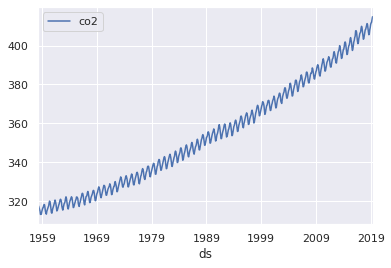

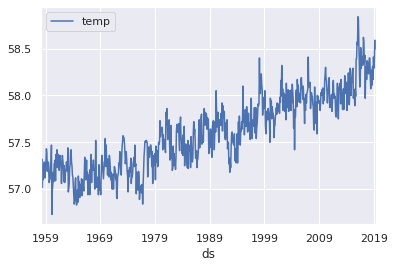

In [11]:
print(df[['co2']].plot())
print(df[['temp']].plot())

In [12]:
df.corr()

,co2,temp
co2,1.000000,0.898635
temp,0.898635,1.000000


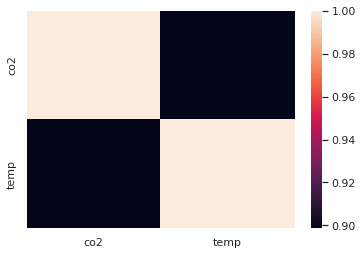

In [13]:
sns.heatmap(df.corr())

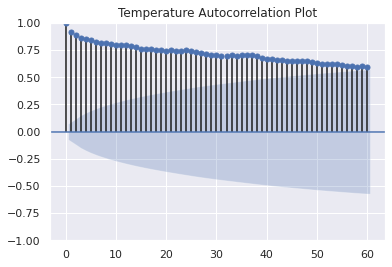

In [14]:
p = plot_acf(df['temp'], lags=60, title='Temperature Autocorrelation Plot')

## Part 2. 35 pts – ARIMA with external regressors

### 2.A. 7 pts Split Temp into train test. Determine the transformation, seasonal differencing & non seasonal differencing orders if required. Include the following: plot of differenced data, ADF results, kpss results, ACF/PACF plots.
- When initially loading the original time series data for temperature, we can immediately notice it has an upward trend and changing mean but uniform variance. Thus by definition it is not showing stationarity 
- After a first seasonal differencing, the plot is observed to remain around zero for most of the time, a characteristic of stationarity. We can then confirm stationarity in the dataset by employing KPSS and ADFuller tests. 
- We determine the order by differencing the data and applying ADF and KPSS tests. After the second pass, ADF test shows the p-values are less than 0.05 so the Null hypothesis can be rejected. If it is not null then we know the TS does npt possess a unit root and hence is stationary. Rejecting the Null hypothesis would mean TS is not stationary. KPSS tests also show the p-values are greater than 0.05. This means that the Null hypothesis of stationarity cannot be rejected. If it is null then we know the TS has stationary characteristics. Alternate hypothesis would mean TS is not stationary.
- The ACF plot reveal autocorrelation is present. Seasonality is observed in the PACF plot.
- Stationarity is achieved after differencing the data once each for seasonal & non-seasonal differencing orders.

In [15]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

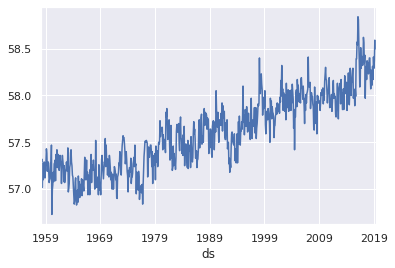

In [16]:
# selecting variable of intest & build uniform univariate time series
ts_temp = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp'].mean()
ts_temp.plot()

In [17]:
# take a log transformation
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts_temp)

### Split into Train/test ( )

In [18]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts_temp)

In [19]:
print(y_train.index.min(), y_train.index.max())
print(y_test.index.min(), y_test.index.max())
print(y_train.shape)
print(y_test.shape)

1958-03 2004-01
2004-02 2019-05
(551,)
(184,)


### Examine Stationarity

In [20]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [21]:
adf_test(y_train)

Dickey-Fuller Test Result:
Test Statistic                  -2.481183
p-value                          0.120120
#Lags Used                       4.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64


In [22]:
adf_temp = adfuller(y_train)
ad_fuller_pval = adf_temp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: FALSE


In [23]:
kpss_test(y_train)

KPSS Test Result:
Test Statistic            2.970537
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [24]:
kpss_temp = kpss(y_train)
kpss_pval = kpss_temp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


### No stationarity in original temp y_train... Difference the data and examine again

In [25]:
y_train_seasdiff = y_train.diff(12).dropna()
print(y_train_seasdiff)

ds
1959-03    0.05
1959-04    0.09
1959-05   -0.13
1959-06    0.25
1959-07    0.02
           ... 
2003-09    0.01
2003-10    0.22
2003-11   -0.07
2003-12    0.32
2004-01   -0.21
Freq: M, Name: temp, Length: 539, dtype: float64


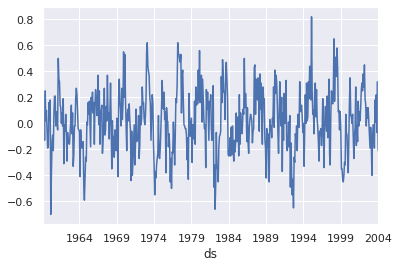

In [26]:
y_train_seasdiff.plot()
plt.show()

In [27]:
adf_test(y_train_seasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.250434e+00
p-value                        1.785978e-10
#Lags Used                     1.300000e+01
Number of Observations Used    5.250000e+02
Critical Value (1%)           -3.442867e+00
Critical Value (5%)           -2.867061e+00
Critical Value (10%)          -2.569710e+00
dtype: float64


In [28]:
adf_temp = adfuller(y_train_seasdiff)
ad_fuller_pval = adf_temp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [29]:
kpss_test(y_train_seasdiff)

KPSS Test Result:
Test Statistic            0.044985
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [30]:
kpss_temp = kpss(y_train_seasdiff)
kpss_pval = kpss_temp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


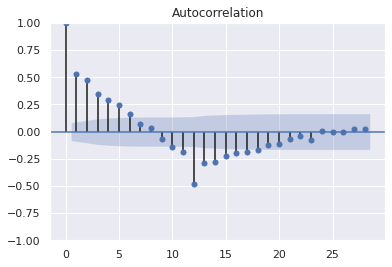

In [31]:
plot_acf(y_train_seasdiff)
plt.show()

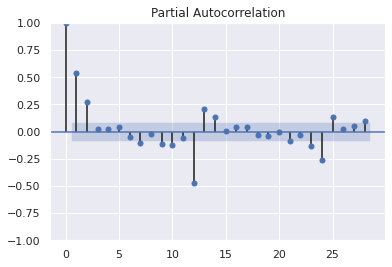

In [32]:
plot_pacf(y_train_seasdiff)
plt.show()

In [33]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

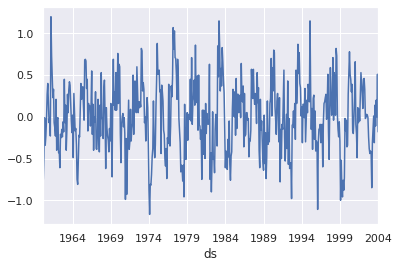

In [34]:
y_train_nonseasdiff.plot()
plt.show()

In [35]:
adf_test(y_train_nonseasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.555800e+00
p-value                        3.102015e-11
#Lags Used                     1.300000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64


In [36]:
adf_temp = adfuller(y_train_nonseasdiff)
ad_fuller_pval = adf_temp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [37]:
kpss_test(y_train_nonseasdiff)

KPSS Test Result:
Test Statistic            0.009799
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [38]:
kpss_temp = kpss(y_train_nonseasdiff)
kpss_pval = kpss_temp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


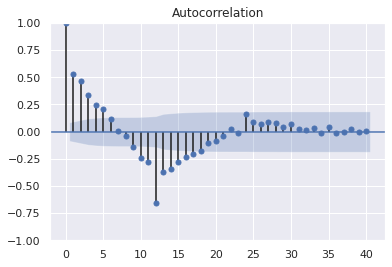

In [39]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

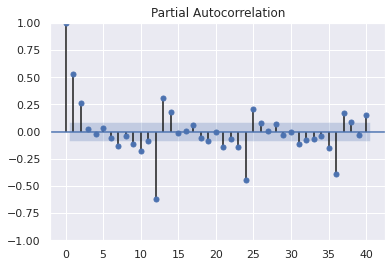

In [40]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.B. 7 pts Fit a SARIMA or ARIMA model based on your examinations. Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results. Check if auto arima gives you a different order. If this is a better model, examine the residuals of this model.

In [41]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,1,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                 117.304
Date:                             Sat, 14 May 2022   AIC                           -224.608
Time:                                     13:08:44   BIC                           -203.169
Sample:                                 03-31-1958   HQIC                          -216.222
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3835      0.045      8.587      0.000       0.296       0.471
ar.L2          0.2620      

In [42]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (3, 1, 1)(0, 1, 0, 12): -224.49550706908607


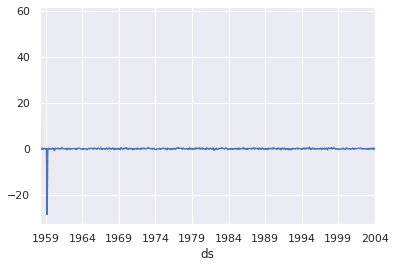

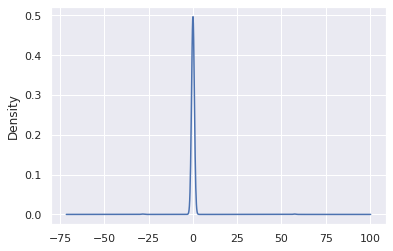

count    551.000000
mean       0.055174
std        2.739116
min      -28.550001
25%       -0.120285
50%       -0.000120
75%        0.125864
max       57.380000
dtype: float64


In [43]:
# residual checks
# line plot of residuals
residuals = sarima_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [44]:
residuals

ds
1958-03    57.380000
1958-04    -0.089999
1958-05     0.030000
1958-06    -0.300000
1958-07     0.250000
             ...    
2003-09    -0.014296
2003-10     0.168874
2003-11    -0.167513
2003-12     0.283619
2004-01    -0.326205
Freq: M, Length: 551, dtype: float64

In [45]:
resid = residuals[24:]
resid

ds
1960-03   -0.797779
1960-04   -0.144174
1960-05    0.220645
1960-06    0.107033
1960-07   -0.110958
             ...   
2003-09   -0.014296
2003-10    0.168874
2003-11   -0.167513
2003-12    0.283619
2004-01   -0.326205
Freq: M, Length: 527, dtype: float64

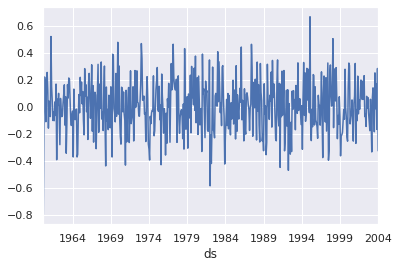

In [46]:
resid.plot()

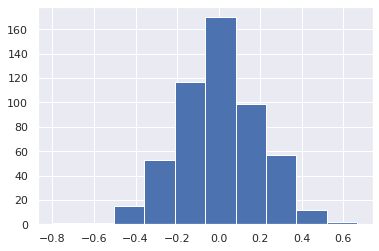

In [47]:
resid.hist()

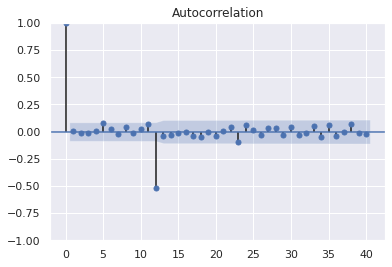

In [48]:
plot_acf(resid, lags = 40)
plt.show()

In [49]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,5.38012,0.864384,5.298779,0.870347


### Checking against auto_arima()

In [50]:
from sktime.forecasting.arima import AutoARIMA
from pmdarima.arima import auto_arima

### Fresh split into train and test (temperature data) for Modeling

In [51]:
y_train, y_test = temporal_train_test_split(ts_temp)

In [52]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [53]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

## Model 1 (AutoARIMA)

In [54]:
arima_model = AutoARIMA(D=1, sp=12)
arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

In [55]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                 234.125
Date:                             Sat, 14 May 2022   AIC                           -458.250
Time:                                     13:12:23   BIC                           -436.802
Sample:                                          0   HQIC                          -449.861
                                             - 551                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8809      0.033     26.698      0.000       0.816       0.946
ma.L1         -0.4936      

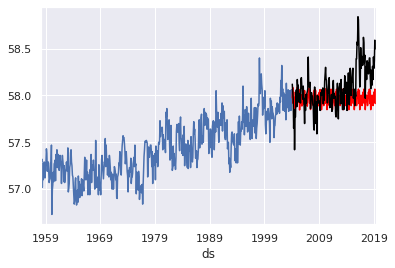

In [56]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## Model 2 (auto_arima)

In [57]:
auto_arima = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_arima.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-53.968, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-345.175, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-167.230, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-395.722, Time=1.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-284.630, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-405.606, Time=1.47 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-353.561, Time=0.68 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.46 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-424.092, Time=1.82 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-367.3

In [58]:
print(auto_arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 223.904
Date:                             Sat, 14 May 2022   AIC                           -433.808
Time:                                     13:14:55   BIC                           -403.793
Sample:                                          0   HQIC                          -422.067
                                             - 551                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.134      0.255      0.799      -0.228       0.296
ar.L2          0.0368      

Figure(864x576)


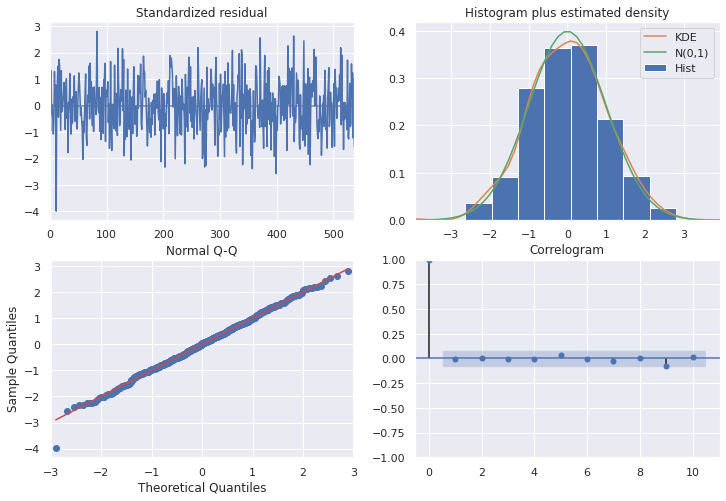

In [59]:
print(auto_arima.plot_diagnostics(figsize=(12,8)))

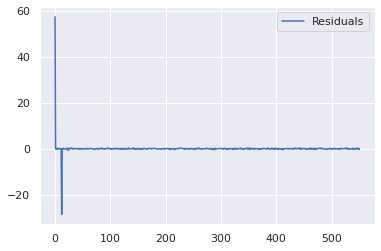

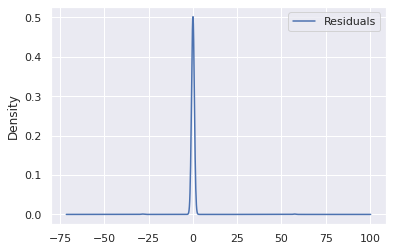

        Residuals
count  551.000000
mean     0.052828
std      2.736996
min    -28.550000
25%     -0.108642
50%      0.006010
75%      0.110697
max     57.380000


In [60]:
# residual checks
# line plot of residuals
res = auto_arima.resid()
residuals = pd.DataFrame(res,columns=["Residuals"])
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [61]:
resid = residuals[24:]
resid

,Residuals
24,-0.763389
25,-0.015780
26,0.144974
27,0.252910
28,-0.074610
...,...
546,0.046744
547,0.194460
548,-0.193679
549,0.160406


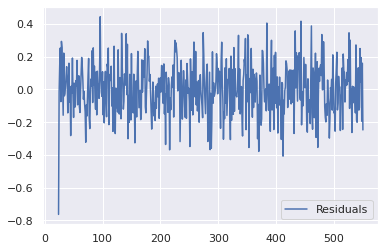

In [62]:
resid.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e1a384910>]],
      dtype=object)

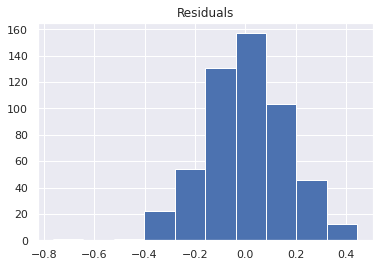

In [63]:
resid.hist()

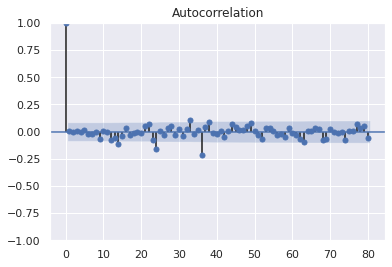

In [64]:
plot_acf(resid, lags = 80)
plt.show()

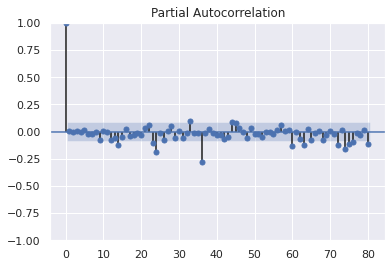

In [65]:
plot_pacf(resid, lags = 80)
plt.show()

In [66]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.571788,0.964604,3.501685,0.967041


### 2.C. 7 pts Using your best model, predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [67]:
y_pred = pd.DataFrame(auto_arima.predict(n_periods = len(y_test)), index = y_test.index)
y_pred.columns = ['pred']
y_pred

,pred
ds,
2004-02,58.028627
2004-03,58.108983
2004-04,57.984528
2004-05,58.084765
2004-06,57.916936
...,...
2019-01,58.553866
2019-02,58.521579
2019-03,58.595127


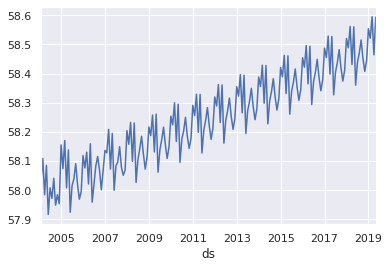

In [68]:
# selecting variable of intest & build uniform univariate time series
y_pred = y_pred.groupby(pd.PeriodIndex(y_pred.index, freq="M"))['pred'].mean()
y_pred.plot()

In [69]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

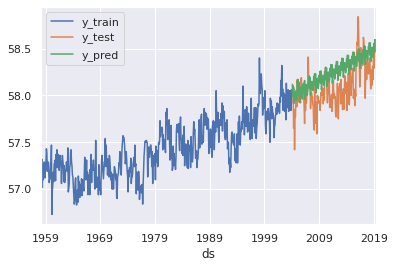

In [70]:
# model prediction
plot_results(y_train, y_test, y_pred)

In [71]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [72]:
#calculate SMAPE
smape(y_test, y_pred)

0.34422784644276183

In [73]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

1.5679160886858377

In [74]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

0.20012310804681058

In [75]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

0.06042945368794782

In [76]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.003450331712048208

### 2.D. 7 pts Refit your best model by adding co2 as an external regressor. Examine the residuals of this model.

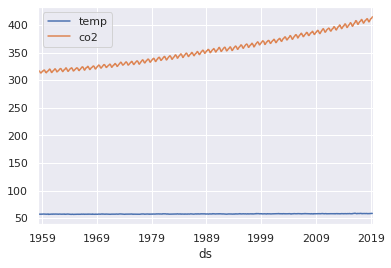

In [77]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp', 'co2'].mean()
ts.plot()

In [78]:
y_train, y_test = temporal_train_test_split(ts)

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Best model:  ARIMA(3,1,1)(2,1,0)[12]  
sarimax_model = SARIMAX(endog=y_train['temp'],
                        exog = y_train['co2'],
                        order=(3,1,1),
                        trend='c',
                        seasonal_order=(2, 1, 0, 12))
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Sat, 14 May 2022   AIC                           -430.023
Time:                                     13:15:15   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0097      

In [80]:
# Return AICc
print("AICc for order " + str(sarimax_model.order) + str(sarimax_model.seasonal_order) +": " +str(sarimax_fit.aicc))

AICc for order (3, 1, 1)(2, 1, 0, 12): -429.6824920506663


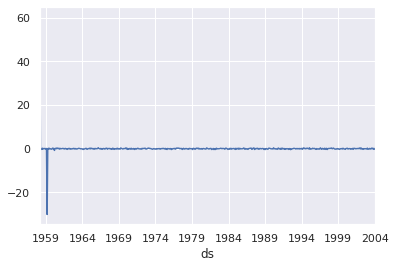

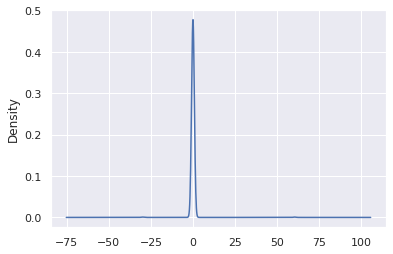

count    551.000000
mean       0.054703
std        2.882845
min      -30.081279
25%       -0.109683
50%        0.004615
75%        0.109658
max       60.445055
dtype: float64


In [81]:
# residual checks
# line plot of residuals
residuals = sarimax_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [82]:
residuals

ds
1958-03    60.445055
1958-04    -0.073209
1958-05     0.030382
1958-06    -0.308211
1958-07     0.241789
             ...    
2003-09     0.045396
2003-10     0.194082
2003-11    -0.197412
2003-12     0.155529
2004-01    -0.250193
Freq: M, Length: 551, dtype: float64

In [83]:
resid = residuals[24:]
resid

ds
1960-03   -0.760817
1960-04   -0.014800
1960-05    0.152592
1960-06    0.257897
1960-07   -0.072371
             ...   
2003-09    0.045396
2003-10    0.194082
2003-11   -0.197412
2003-12    0.155529
2004-01   -0.250193
Freq: M, Length: 527, dtype: float64

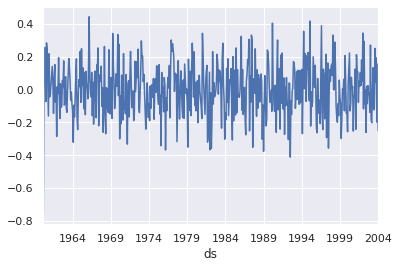

In [84]:
resid.plot()

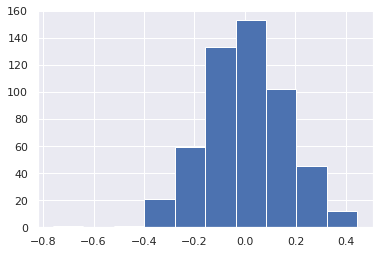

In [85]:
resid.hist()

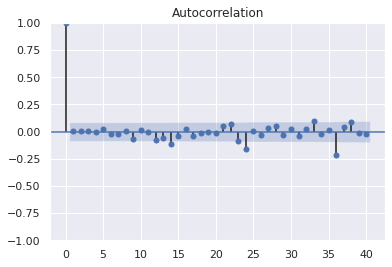

In [86]:
plot_acf(resid, lags = 40)
plt.show()

In [87]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.501347,0.967053,3.432918,0.969327


### 2.E. 7 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [88]:
y_pred = sarimax_fit.forecast(steps = len(y_test['temp']),  exog=y_test['co2'])

In [89]:
y_train

,temp,co2
ds,,
1958-03,57.38,315.700
1958-04,57.29,317.450
1958-05,57.32,317.510
1958-06,57.02,316.685
1958-07,57.27,315.860
...,...,...
2003-09,58.02,372.980
2003-10,58.05,373.000
2003-11,57.84,374.350


In [90]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

mae =  mean_absolute_error(y_pred, y_test['temp'])
mse = mean_squared_error(y_pred, y_test['temp'])
mape = mean_absolute_percentage_error(y_pred, y_test['temp'])
smape = smape(np.array(y_pred), np.array(y_test['temp']))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_test['temp'], y_train=y_train['temp'])

In [91]:
print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Seasonal Arima errors
MAE: 0.3055643484278933
MSE: 0.1277373148574044
MAPE: 0.005227391589696323
SMAPE: 0.5245846308345824
MASE: 2.3940226728681098


In [92]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Sat, 14 May 2022   AIC                           -430.023
Time:                                     13:15:17   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0097      0.022     -0.446      0.655      -0.052       0.033
ar.L1          0.0165      0.146      0.113      0.910      -0.270       0.303
ar.L2          0.0278      0.089      0.314      0.753      -0.146       0.202
ar.L3         -0.1175      0.061     -1.915      0.056      -0.238       0.003
ma.L1         -0.5834      0.140     -4.155      0.000      -0.859      -0.308
ar.S.L12      -0.7436      0.041    -18.355      0.000      -0.823      -0.664
ar.S.L24      -0.3330      0.040     -8.241      0.000      -0.412      -0.254
sigma2         0.0251      0.002     16.587      0.000       0.022       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.92   Prob(JB):                         0.75
Heteroskedasticity (H):               1.13   Skew:                            -0.07
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Part 3. 35 pts – Prophet with additional regressors

### 3.A. 10 pts Using the same train test split as part 2, fit a prophet model to your NON-differenced training set. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [93]:
! pip install pystan --user
! pip install fbprophet --user

In [94]:
! pip install wbdata

In [95]:
from util_prophet import *
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [96]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'temp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'temp':'y'}, inplace=True)

In [97]:
y_train_prophet

,y,co2,ds
1958-03,57.38,315.700,1958-03
1958-04,57.29,317.450,1958-04
1958-05,57.32,317.510,1958-05
1958-06,57.02,316.685,1958-06
1958-07,57.27,315.860,1958-07
...,...,...,...
2003-09,58.02,372.980,2003-09
2003-10,58.05,373.000,2003-10
2003-11,57.84,374.350,2003-11
2003-12,58.06,375.690,2003-12


In [98]:
y_train_prophet['ds'] = y_train_prophet['ds'].dt.strftime('%Y-%m')
print(y_train_prophet)

             y      co2       ds
1958-03  57.38  315.700  1958-03
1958-04  57.29  317.450  1958-04
1958-05  57.32  317.510  1958-05
1958-06  57.02  316.685  1958-06
1958-07  57.27  315.860  1958-07
...        ...      ...      ...
2003-09  58.02  372.980  2003-09
2003-10  58.05  373.000  2003-10
2003-11  57.84  374.350  2003-11
2003-12  58.06  375.690  2003-12
2004-01  57.92  376.790  2004-01

[551 rows x 3 columns]


In [99]:
model = Prophet()
model.fit(y_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [100]:
future_data = model.make_future_dataframe(periods=len(y_test), freq='m')

In [101]:
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

,0,1,2
ds,1958-03-01 00:00:00,1958-04-01 00:00:00,1958-05-01 00:00:00
trend,57.215189,57.215493,57.215787
yhat_lower,57.086823,57.07275,57.047568
yhat_upper,57.465232,57.454761,57.428443
trend_lower,57.215189,57.215493,57.215787
trend_upper,57.215189,57.215493,57.215787
additive_terms,0.062528,0.031737,0.020392
additive_terms_lower,0.062528,0.031737,0.020392
additive_terms_upper,0.062528,0.031737,0.020392
yearly,0.062528,0.031737,0.020392


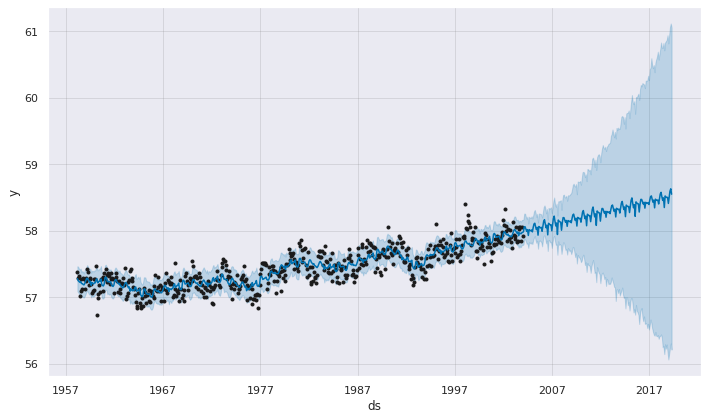

In [102]:
p = model.plot(forecast_data)

In [103]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1958-03-01,57.215189,57.086823,57.465232,57.215189,57.215189,0.062528,0.062528,0.062528,0.062528,0.062528,0.062528,0.0,0.0,0.0,57.277717
1,1958-04-01,57.215493,57.072750,57.454761,57.215493,57.215493,0.031737,0.031737,0.031737,0.031737,0.031737,0.031737,0.0,0.0,0.0,57.247230
2,1958-05-01,57.215787,57.047568,57.428443,57.215787,57.215787,0.020392,0.020392,0.020392,0.020392,0.020392,0.020392,0.0,0.0,0.0,57.236179
3,1958-06-01,57.216091,57.034472,57.414895,57.216091,57.216091,0.007273,0.007273,0.007273,0.007273,0.007273,0.007273,0.0,0.0,0.0,57.223364
4,1958-07-01,57.216385,57.053431,57.429487,57.216385,57.216385,0.018871,0.018871,0.018871,0.018871,0.018871,0.018871,0.0,0.0,0.0,57.235255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2018-12-31,58.493866,56.062716,60.815359,56.196467,60.926419,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,0.0,0.0,0.0,58.409208
731,2019-01-31,58.496772,56.152361,60.945892,56.173862,60.957196,0.011692,0.011692,0.011692,0.011692,0.011692,0.011692,0.0,0.0,0.0,58.508464
732,2019-02-28,58.499396,56.233727,61.058485,56.153445,60.988603,0.092830,0.092830,0.092830,0.092830,0.092830,0.092830,0.0,0.0,0.0,58.592226
733,2019-03-31,58.502302,56.303357,61.114369,56.127814,61.021028,0.127100,0.127100,0.127100,0.127100,0.127100,0.127100,0.0,0.0,0.0,58.629401


In [104]:
ind = 551
y_pred = forecast_data[ind:]['yhat']
y_true = y_test['y']

In [105]:
mae =  mean_absolute_error(y_pred, y_true)
mse = mean_squared_error(y_pred, y_true)
mape = mean_absolute_percentage_error(y_pred, y_true)
smape = smape(np.array(y_pred), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_true, y_train=y_train['y'])

print('Non-differenced Prophet errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Non-differenced Prophet errors
MAE: 0.20773835449953923
MSE: 0.0637022071638246
MAPE: 0.0035648442619457877
SMAPE: 0.35730426819346245
MASE: 1.6275797004949653


### 3.B. 10 pts Adjust seasonality, changepoint priors or other methods to see if you can create a better fit model. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [106]:
model_seasonal = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
model_seasonal.fit(y_train_prophet)
future_data_s = model_seasonal.make_future_dataframe(periods=len(y_test), freq='m')
forecast_data_s = model_seasonal.predict(future_data_s)
forecast_data_s.iloc[0:3].T

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,0,1,2
ds,1958-03-01 00:00:00,1958-04-01 00:00:00,1958-05-01 00:00:00
trend,57.258126,57.252792,57.247631
yhat_lower,57.145589,57.104178,57.089219
yhat_upper,57.499728,57.457147,57.448086
trend_lower,57.258126,57.252792,57.247631
trend_upper,57.258126,57.252792,57.247631
additive_terms,0.060569,0.030984,0.020538
additive_terms_lower,0.060569,0.030984,0.020538
additive_terms_upper,0.060569,0.030984,0.020538
yearly,0.060569,0.030984,0.020538


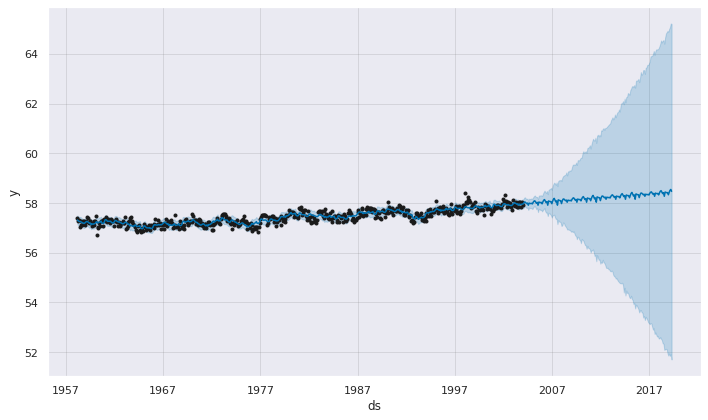

In [107]:
p_s = model_seasonal.plot(forecast_data_s)

In [108]:
ind_s = 551
y_pred_s = forecast_data_s[ind:]['yhat']

In [109]:
mae =  mean_absolute_error(y_pred_s, y_true)
mse = mean_squared_error(y_pred_s, y_true)
mape = mean_absolute_percentage_error(y_pred_s, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_s, y_true, y_train=y_train['y'])

print('Seasonal Adjusted Prophet errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Seasonal Adjusted Prophet errors
MAE: 0.17691574240883137
MSE: 0.04910700265611346
MAPE: 0.0030388852941335915
MASE: 1.3860919989295903


### 3.C. 10 pts Using your best prophet model, include co2 as an external regressor. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [110]:
y_train, y_test = temporal_train_test_split(ts)

In [111]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'temp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'temp':'y'}, inplace=True)

In [112]:
y_train_prophet['ds'] = y_train_prophet['ds'].dt.strftime('%Y-%m')

In [113]:
y_train_prophet

,y,co2,ds
ds,,,
1958-03,57.38,315.700,1958-03
1958-04,57.29,317.450,1958-04
1958-05,57.32,317.510,1958-05
1958-06,57.02,316.685,1958-06
1958-07,57.27,315.860,1958-07
...,...,...,...
2003-09,58.02,372.980,2003-09
2003-10,58.05,373.000,2003-10
2003-11,57.84,374.350,2003-11


In [114]:
y_test_prophet

,y,co2,ds
ds,,,
2004-02,58.12,377.37,2004-02
2004-03,58.04,378.39,2004-03
2004-04,57.96,380.50,2004-04
2004-05,57.65,380.62,2004-05
2004-06,57.85,379.55,2004-06
...,...,...,...
2019-01,58.29,410.92,2019-01
2019-02,58.37,411.66,2019-02
2019-03,58.59,412.00,2019-03


In [115]:
# Python
model = Prophet()
model.fit(y_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [116]:
future_data = model.make_future_dataframe(periods=len(y_test), freq='m')

In [117]:
model_seasonal = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
model_seasonal.add_regressor('co2')
model_seasonal.fit(y_train_prophet)
future_data_s = model_seasonal.make_future_dataframe(periods=len(y_test), freq='m')
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,0,1,2
ds,1958-03-01 00:00:00,1958-04-01 00:00:00,1958-05-01 00:00:00
trend,57.215189,57.215493,57.215787
yhat_lower,57.095134,57.061725,57.053791
yhat_upper,57.468202,57.437656,57.415308
trend_lower,57.215189,57.215493,57.215787
trend_upper,57.215189,57.215493,57.215787
additive_terms,0.062528,0.031737,0.020392
additive_terms_lower,0.062528,0.031737,0.020392
additive_terms_upper,0.062528,0.031737,0.020392
yearly,0.062528,0.031737,0.020392


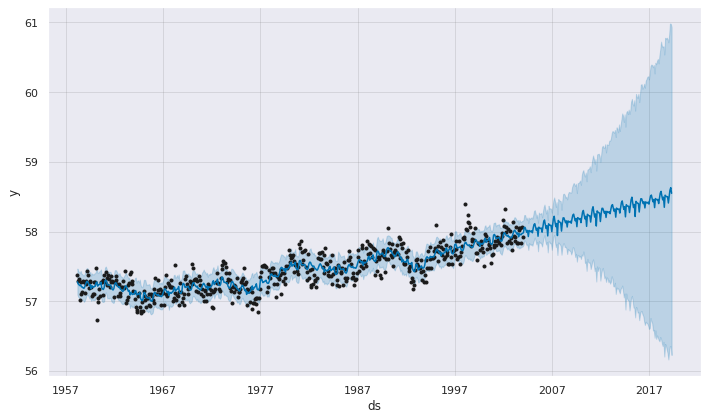

In [118]:
p_r = model_seasonal.plot(forecast_data)

In [119]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1958-03-01,57.215189,57.095134,57.468202,57.215189,57.215189,0.062528,0.062528,0.062528,0.062528,0.062528,0.062528,0.0,0.0,0.0,57.277717
1,1958-04-01,57.215493,57.061725,57.437656,57.215493,57.215493,0.031737,0.031737,0.031737,0.031737,0.031737,0.031737,0.0,0.0,0.0,57.247230
2,1958-05-01,57.215787,57.053791,57.415308,57.215787,57.215787,0.020392,0.020392,0.020392,0.020392,0.020392,0.020392,0.0,0.0,0.0,57.236179
3,1958-06-01,57.216091,57.023707,57.407833,57.216091,57.216091,0.007273,0.007273,0.007273,0.007273,0.007273,0.007273,0.0,0.0,0.0,57.223364
4,1958-07-01,57.216385,57.027318,57.435923,57.216385,57.216385,0.018871,0.018871,0.018871,0.018871,0.018871,0.018871,0.0,0.0,0.0,57.235255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2018-12-31,58.493866,56.163239,60.715220,56.251361,60.843148,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,0.0,0.0,0.0,58.409208
731,2019-01-31,58.496772,56.290335,60.832557,56.242664,60.866725,0.011692,0.011692,0.011692,0.011692,0.011692,0.011692,0.0,0.0,0.0,58.508464
732,2019-02-28,58.499396,56.356654,60.985098,56.236092,60.888022,0.092830,0.092830,0.092830,0.092830,0.092830,0.092830,0.0,0.0,0.0,58.592226
733,2019-03-31,58.502302,56.348506,60.981579,56.228886,60.911462,0.127100,0.127100,0.127100,0.127100,0.127100,0.127100,0.0,0.0,0.0,58.629401


In [120]:
ind_r = 551
y_pred_r = forecast_data[ind:]['yhat']

mae =  mean_absolute_error(y_pred_r, y_true)
mse = mean_squared_error(y_pred_r, y_true)
mape = mean_absolute_percentage_error(y_pred_r, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_r, y_true, y_train=y_train['y'])

print('Prophet Added Regressor errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Prophet Added Regressor errors
MAE: 0.20773835449953923
MSE: 0.0637022071638246
MAPE: 0.0035648442619457877
MASE: 1.6275797004949653


### 3.D. 5 pts Give a summary of your modeling in prophet. What improved the model, what made the fit worse. Give your reasonings why this would happen given the patterns in the data.
- For our prophet model, the seasonality used was 10 while the AutoARIMA Best model was:  ARIMA(1,1,1)(0,1,1)[12]
- Comparison of various error measurements (e.g., MAE, MSE, MAPE, sMAPE, MASE) we can see very similar values, but if given the choice in a professional setting I would use Seasonal Adjusted Prophet. The errors are listed below:
- Non-differenced Prophet errors:
  - MAE: 0.20012310804681058
  - MSE: 0.06042945368794782
  - MAPE: 0.0034342826435053474
  - SMAPE: 0.34422784644276183
  - MASE: 1.5679160886858377
- Seasonal Adjusted Prophet errors
  - MAE: 0.17691574240883137
  - MSE: 0.04910700265611346
  - MAPE: 0.0030388852941335915
  - MASE: 1.3860919989295903
- Prophet Added Regressor errors: 
  - MAE: 0.20773835449953923
  - MSE: 0.0637022071638246
  - MAPE: 0.0035648442619457877
  - MASE: 1.6275797004949653
- The advantage of adjusting for seasonal over the other Prophet models is that after data preprocessing step we can see what is a better seasonality and change point priors to better fit our model. In other words, we have more control by "custom fitting" for a better estimate of seasonality and change points. 

## Part 4. 10 pts – conclusion

### 4.A. 5 pts Which was the best model according to your error metrics?

The best model according to my error metrics was Seasonally adjusted prophet. We repeat our error metrics here again:

- Seasonal Adjusted Prophet errors
  - MAE: 0.17691574240883137
  - MSE: 0.04910700265611346
  - MAPE: 0.0030388852941335915
  - MASE: **1.3860919989295903**

### 4.B. 5 pts If you had this data for 100 locations (different pairs of time series), how would you approach modeling this data?

I would probably try the approach for Vector Auto Regression (VAR). In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables. In our example above with temperature and Carbon dioxide, since the aim is to predict the temperature, we can simply remove the other variables (except temperature) and fit a model on the remaining univariate series. Another simple idea is to forecast values for each series individually using the techniques we already know (SARIMA, AutoARIMA, Prophet non-diff, Prophet Seasonally adjusted).

